In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold, StratifiedKFold
from skopt import BayesSearchCV
import sys
from sklearn.ensemble import RandomForestClassifier, VotingClassifier, AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score, f1_score
from sklearn.metrics import roc_curve, auc
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import learning_curve
from sklearn.base import clone
from collections import Counter
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.inspection import permutation_importance

# Defining train_model function

In [ ]:
def train_model(X, y):
    base_model = DecisionTreeClassifier(random_state=42)
    adaboost_model = AdaBoostClassifier(base_model, random_state=42)
    model2 = RandomForestClassifier(random_state=42)
    model = VotingClassifier(estimators=[('adaboost', adaboost_model), ('random_forest', model2)], voting='soft')
    
    param_grid = {
    'random_forest__n_estimators': [100, 500, 1000, 1500, 2000],
    'random_forest__max_depth': [None, 10, 20, 30, 40, 50, 60],
    'random_forest__max_features': [None, 'sqrt', 'log2', 0.5],
    'random_forest__min_samples_split': [2, 5, 10, 20, 40],
    'random_forest__min_samples_leaf': [1, 2, 4, 8, 16],
    'random_forest__bootstrap': [True, False],
    'adaboost__n_estimators': [100, 1000, 2000],
    'adaboost__learning_rate': [0.001, 0.01, 0.1, 0.5, 1.0]
    }
    metrics_dict = {
        'test_accuracy': [],
        'test_precision': [],
        'test_recall': [],
        'test_roc_auc': [],
        'test_f1': [],
        'train_accuracy': [],
        'train_precision': [],
        'train_recall': [],
        'train_roc_auc': [],
        'train_f1': []
    }
    
    cv_results = []
    best_models = []
    best_indices = []
    
    outer_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    
    for train_index, test_index in outer_cv.split(X, y):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        print("\n============================")
        print("Dataset Splits Info")
        print("----------------------------")
        print(f"Train set before SMOTE: {X_train.shape[0]} samples")
        print("Class distribution before SMOTE:", Counter(y_train))

        smote = SMOTE(sampling_strategy='auto', random_state=42)
        X_train, y_train = smote.fit_resample(X_train, y_train)

        print(f"\nTrain set after SMOTE:  {X_train.shape[0]} samples")
        print("Class distribution after SMOTE:", Counter(y_train))
        print(f"Test set:               {X_test.shape[0]} samples")
        print("Class distribution in Test:", Counter(y_test))
        print("============================\n")
        
        inner_cv = KFold(n_splits=10, shuffle=True, random_state=42)
        
        bayes_search = BayesSearchCV(
            estimator=model,
            search_spaces=param_grid,
            n_iter=30,  # Number of iterations for optimization
            cv=inner_cv,
            scoring='accuracy',
            n_jobs=-1,
            random_state=42
        )
        
        bayes_search.fit(X_train, y_train)
        best_model = bayes_search.best_estimator_
        best_model.fit(X_train, y_train)
        
        predictions = best_model.predict(X_test)
        predictions_train = best_model.predict(X_train)
        predictions_2 = best_model.predict_proba(X_test)
        predictions_2_train = best_model.predict_proba(X_train)
        
        test_accuracy = accuracy_score(y_test, predictions)
        test_precision = precision_score(y_test, predictions, average='macro')
        test_recall = recall_score(y_test, predictions, average='macro')
        # test_roc_auc = roc_auc_score(y_test, predictions_2,  multi_class='ovr')
        test_f1 = f1_score(y_test, predictions, average='macro')
        
        train_accuracy = accuracy_score(y_train, predictions_train)
        train_precision = precision_score(y_train, predictions_train, average='macro')
        train_recall = recall_score(y_train, predictions_train, average='macro')
        # train_roc_auc = roc_auc_score(y_train, predictions_2_train,  multi_class='ovr')
        train_f1 = f1_score(y_train, predictions_train, average='macro')
        
        metrics_dict['test_accuracy'].append(test_accuracy)
        metrics_dict['test_precision'].append(test_precision)
        metrics_dict['test_recall'].append(test_recall)
        # metrics_dict['test_roc_auc'].append(test_roc_auc)
        metrics_dict['test_f1'].append(test_f1)
        metrics_dict['train_accuracy'].append(train_accuracy)
        metrics_dict['train_precision'].append(train_precision)
        metrics_dict['train_recall'].append(train_recall)
        # metrics_dict['train_roc_auc'].append(train_roc_auc)
        metrics_dict['train_f1'].append(train_f1)
        
        cv_results.append(bayes_search.cv_results_)
        best_models.append(best_model)
        best_indices.append(bayes_search.best_index_)
    
    avg_metrics = {k: np.mean(v) for k, v in metrics_dict.items()}
    
    best_model_index = np.argmax(metrics_dict['test_accuracy'])
    best_model_overall = best_models[best_model_index]
    
    return avg_metrics, best_model_overall, y_test, X_test, metrics_dict, predictions_2

# Main code

In [ ]:
df = pd.read_csv(r'../output_combined_2.csv')
df = df.dropna()
replacement_dict = {'Non': 0, 'NPF': 1}
# replacement_dict = {'Non': 0, 'NPF': 1, 'undefined': 2}
df['day.type'] = df['day.type'].replace(replacement_dict)
df_orig = df

C:\Users\Masloriy\AppData\Local\Temp\ipykernel_660\2162326416.py:7: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['day.type'] = df['day.type'].replace(replacement_dict)


# P4


Dataset Splits Info
----------------------------
Train set before SMOTE: 152 samples
Class distribution before SMOTE: Counter({0: 101, 1: 51})

Train set after SMOTE:  202 samples
Class distribution after SMOTE: Counter({0: 101, 1: 101})
Test set:               39 samples
Class distribution in Test: Counter({0: 26, 1: 13})


Dataset Splits Info
----------------------------
Train set before SMOTE: 153 samples
Class distribution before SMOTE: Counter({0: 101, 1: 52})

Train set after SMOTE:  202 samples
Class distribution after SMOTE: Counter({1: 101, 0: 101})
Test set:               38 samples
Class distribution in Test: Counter({0: 26, 1: 12})


Dataset Splits Info
----------------------------
Train set before SMOTE: 153 samples
Class distribution before SMOTE: Counter({0: 102, 1: 51})

Train set after SMOTE:  204 samples
Class distribution after SMOTE: Counter({0: 102, 1: 102})
Test set:               38 samples
Class distribution in Test: Counter({0: 25, 1: 13})


Dataset Splits Inf

c:\Users\Masloriy\Desktop\npf_urban\.venv\Lib\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\Masloriy\Desktop\npf_urban\.venv\Lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


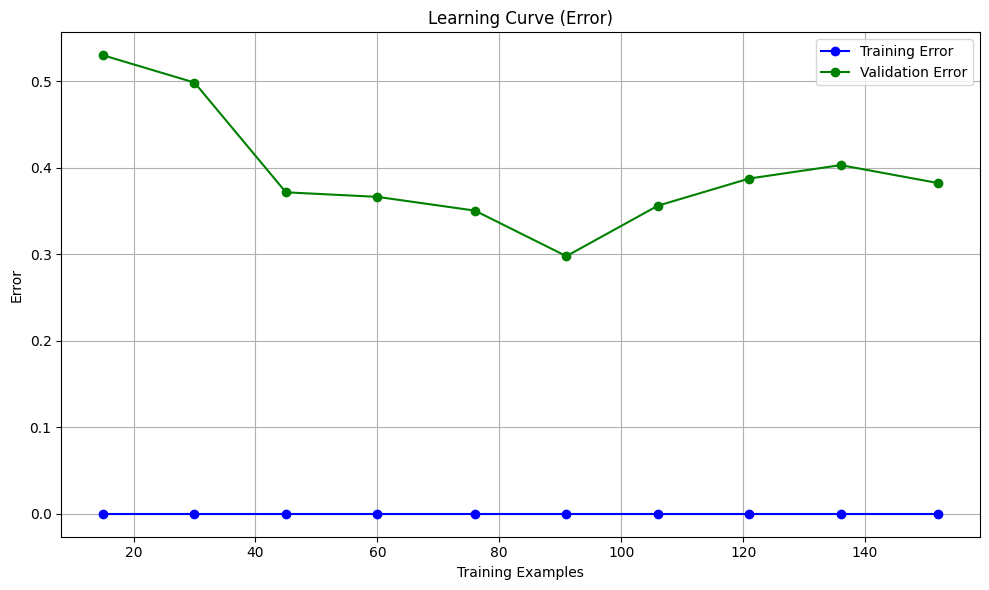

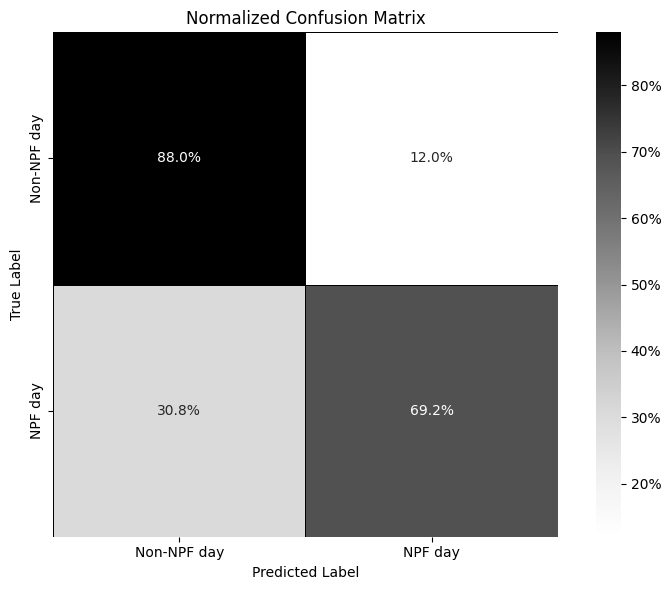

In [ ]:
df_selected = df_orig[["RH", "SRAD", 'temperature', 'pressure', "day.type"]].copy()
df = df_selected

X = df.drop(columns=["day.type"])
y = df["day.type"]

avg_metrics, model, y_test, X_test, metrics_dict, predictions_2 = train_model(X=X, y=y)

perm_result = permutation_importance(model, X_test, y_test, n_repeats=10, random_state=42)
perm_importance_df = pd.DataFrame({
    'Feature': X.columns,
    'Permutation Importance': perm_result.importances_mean,
    'Std Dev': perm_result.importances_std
}).sort_values(by='Permutation Importance', ascending=False)

with open('p4.txt', 'w') as file:
    sys.stdout = file
    print("Test accuracy", avg_metrics['test_accuracy'])
    print("Test precision", avg_metrics['test_precision'])
    print("Test recall", avg_metrics['test_recall'])
    print("Test roc_auc", avg_metrics['test_roc_auc'])
    print("Test f1", avg_metrics['test_f1'])
    print('-------------------------------------------------------------------------------')
    print("Train accuracy", avg_metrics['train_accuracy'])
    print("Train precision", avg_metrics['train_precision'])
    print("Train recall", avg_metrics['train_recall'])
    print("Train roc_auc", avg_metrics['train_roc_auc'])
    print("Train f1", avg_metrics['train_f1'])
    print('-------------------------------------------------------------------------------')
    for i in range(len(metrics_dict['test_accuracy'])):
        print(f"Fold {i+1} - Test Accuracy: {metrics_dict['test_accuracy'][i]:.4f}, Test Precision: {metrics_dict['test_precision'][i]:.4f}, Test Recall: {metrics_dict['test_recall'][i]:.4f}")
    print('-------------------------------------------------------------------------------')
    print("Permutation Importance:")
    print(perm_importance_df)
    print('-------------------------------------------------------------------------------')
    predicted_labels = predictions_2.argmax(axis=1)
    class_accuracies = {}
    for class_label in model.classes_:
        class_indices = (y_test == class_label)
        class_accuracies[class_label] = accuracy_score(y_test[class_indices], predicted_labels[class_indices])
    print("Per-Class Accuracy:")
    for class_label, accuracy in class_accuracies.items():
        print(f"Class {class_label}: {accuracy:.4f}")
    print('-------------------------------------------------------------------------------')
    sys.stdout = sys.__stdout__

replacement_dict = {'0': 'Non-NPF day', '1': 'NPF day'}

class_labels = [replacement_dict.get(str(label), str(label)) for label in model.classes_]

predicted_labels = predictions_2.argmax(axis=1)

cm = confusion_matrix(y_test, predicted_labels, labels=model.classes_)
cm_row_normalized = cm.astype('float') / cm.sum(axis=1, keepdims=True)
annot_row = np.char.add((cm_row_normalized * 100).round(1).astype(str), '%')

plt.figure(figsize=(8, 6))
sns.heatmap(
    cm_row_normalized * 100,
    annot=annot_row,
    fmt="",
    cmap="Greys",
    cbar=True,
    cbar_kws={'format': '%.0f%%'},
    xticklabels=class_labels,
    yticklabels=class_labels,
    linecolor='black',
    linewidths=0.5,
    square=True
)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Normalized Confusion Matrix")
plt.tight_layout()
plt.savefig("p4.png", dpi=300)

# P6

c:\Users\Masloriy\Desktop\npf_urban\.venv\Lib\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\Masloriy\Desktop\npf_urban\.venv\Lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


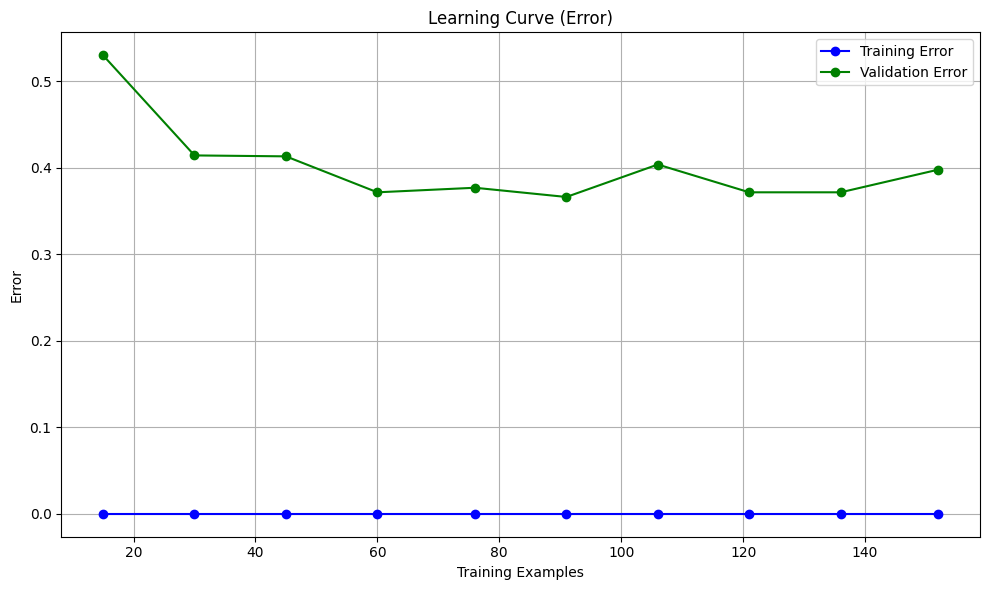

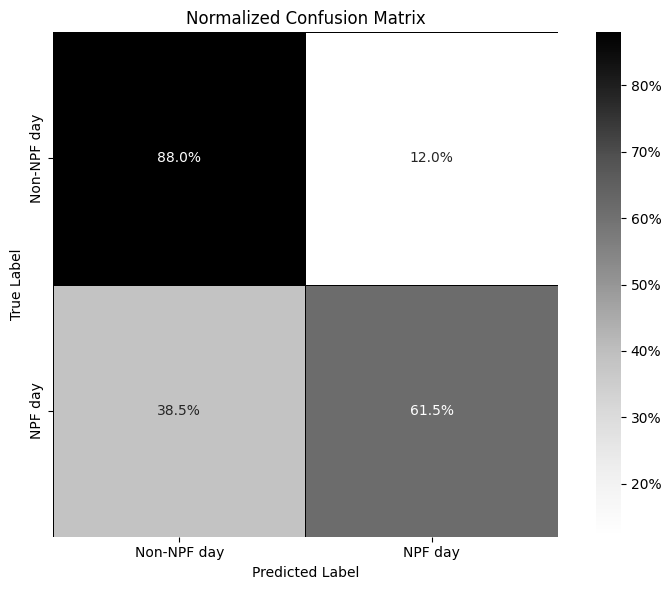

In [ ]:
df_selected = df_orig[["pressure", "RH", "temperature", "SRAD", "day.type",'pm25', 'so2']].copy()
df = df_selected

X = df.drop(columns=["day.type"])
y = df["day.type"]

avg_metrics, model, y_test, X_test, metrics_dict, predictions_2 = train_model(X=X, y=y)

perm_result = permutation_importance(model, X_test, y_test, n_repeats=10, random_state=42)
perm_importance_df = pd.DataFrame({
    'Feature': X.columns,
    'Permutation Importance': perm_result.importances_mean,
    'Std Dev': perm_result.importances_std
}).sort_values(by='Permutation Importance', ascending=False)

with open('p6.txt', 'w') as file:
    sys.stdout = file
    print("Test accuracy", avg_metrics['test_accuracy'])
    print("Test precision", avg_metrics['test_precision'])
    print("Test recall", avg_metrics['test_recall'])
    print("Test roc_auc", avg_metrics['test_roc_auc'])
    print("Test f1", avg_metrics['test_f1'])
    print('-------------------------------------------------------------------------------')
    print("Train accuracy", avg_metrics['train_accuracy'])
    print("Train precision", avg_metrics['train_precision'])
    print("Train recall", avg_metrics['train_recall'])
    print("Train roc_auc", avg_metrics['train_roc_auc'])
    print("Train f1", avg_metrics['train_f1'])
    print('-------------------------------------------------------------------------------')
    for i in range(len(metrics_dict['test_accuracy'])):
        print(f"Fold {i+1} - Test Accuracy: {metrics_dict['test_accuracy'][i]:.4f}, Test Precision: {metrics_dict['test_precision'][i]:.4f}, Test Recall: {metrics_dict['test_recall'][i]:.4f}")
    print('-------------------------------------------------------------------------------')
    print("Permutation Importance:")
    print(perm_importance_df)
    print('-------------------------------------------------------------------------------')
    predicted_labels = predictions_2.argmax(axis=1)
    class_accuracies = {}
    for class_label in model.classes_:
        class_indices = (y_test == class_label)
        class_accuracies[class_label] = accuracy_score(y_test[class_indices], predicted_labels[class_indices])
    print("Per-Class Accuracy:")
    for class_label, accuracy in class_accuracies.items():
        print(f"Class {class_label}: {accuracy:.4f}")
    print('-------------------------------------------------------------------------------')
    sys.stdout = sys.__stdout__

replacement_dict = {'0': 'Non-NPF day', '1': 'NPF day'}

class_labels = [replacement_dict.get(str(label), str(label)) for label in model.classes_]

predicted_labels = predictions_2.argmax(axis=1)

cm = confusion_matrix(y_test, predicted_labels, labels=model.classes_)
cm_row_normalized = cm.astype('float') / cm.sum(axis=1, keepdims=True)
annot_row = np.char.add((cm_row_normalized * 100).round(1).astype(str), '%')

plt.figure(figsize=(8, 6))
sns.heatmap(
    cm_row_normalized * 100,
    annot=annot_row,
    fmt="",
    cmap="Greys",
    cbar=True,
    cbar_kws={'format': '%.0f%%'},
    xticklabels=class_labels,
    yticklabels=class_labels,
    linecolor='black',
    linewidths=0.5,
    square=True
)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Normalized Confusion Matrix")
plt.tight_layout()
plt.savefig("p6.png", dpi=300)